
# Running simulations in parallel with ipyparallel

When using an agent-based model, or any stochastic model or simulation, we frequently want to run it many different times, in order to estimate the distributions of its outputs or how they vary with input parameters. This is an example of an [embarrassingly parallel problem](https://en.wikipedia.org/wiki/Embarrassingly_parallel) (or pleasingly parallel, if you prefer). Since runs of the model are independent, we can speed up the overall process by running them in parallel on different cores on the same machine, or across multiple computers in a cluster.

This tutorial will briefly cover running a model in parallel using Python 3 and [ipyparallel](http://ipyparallel.readthedocs.org/en/stable/index.html) (formerly IPython Parallel). For more details on ipyparallel in general, see the [excellent documentation](http://ipyparallel.readthedocs.org/en/stable/index.html). I'll also use the [Mesa agent-based modeling framework](https://github.com/projectmesa/mesa) for the example model, but this should work with your other favorite Python libraries too. 

## Installing

If you have a recent version of IPython / Jupyter installed, you should already have ipyparallel as well. Otherwise, you can install it with:

```.bash
    $ pip install ipyparallel
```
(or conda instead of pip, if you're using [Anaconda](https://www.continuum.io/downloads)).

If you want to use Mesa, just:

```.sh
    $ pip install mesa
```

## Launching your cluster

The first thing we need to do is launch a cluster, in this case just on our own machine. From the terminal, to launch a four-core cluster, run:

```.sh
    $ ipcluster start -n 4
```

Leave this terminal window running in the background. 

Next, launch a Python interpreter. I *think* this should even work in IDLE, but I suggest opening another terminal window using either IPython

```.sh
    $ ipython
```
Or the Jupyter/IPython notebook:

```.sh
    $ ipython notebook
```

## Connecting to your cluster

In your Python session, first import ipyparallel:


In [1]:
import ipyparallel

Next, connect to the engines, and make sure there are four of them (or however many you decided to launch):

In [2]:
clients = ipyparallel.Client()
clients.ids

[0, 1, 2, 3]

Next, we need to create a [**direct view**](http://ipyparallel.readthedocs.org/en/stable/details.html#directview) into the engines, which will give us direct control over them. (There is also a [**load balanced view**](http://ipyparallel.readthedocs.org/en/stable/details.html#loadbalancedview) which seems both less documented and less suitable for what we're doing here). 

We can do this two ways:

In [3]:
dview = clients[:]

or

In [4]:
dview = clients.direct_view()

To test that everything is working, you can define a trivial function and distribute it to the engines:

In [5]:
def square(x):
    return x**2

In [6]:
results = dview.map_sync(square, range(4))
print(results)

[0, 1, 4, 9]


`map_sync` applies the function given in the first argument to each value given in the second.

You can give more arguments than there are engines, and the system will automatically divide them among the engines. The sync in map_sync means that it will wait until all the results are back before continuing to run. 

If you want to use a function which takes more than one argument, you provide the sequences of arguments one after the other, e.g.:

In [7]:
def multi(a, b):
    return a*b

In [8]:
results = dview.map_sync(multi, [0, 1, 3, 5], [2, 4, 6, 8])
print(results)

[0, 4, 18, 40]


## Simulating $\pi$

One classic simple example of doing science (or math) via numeric simulation is the [Monte Carlo estimation](https://en.wikipedia.org/wiki/Monte_Carlo_method) of $\pi$. You may remember from high school math that the ratio between the areas of a square with side-length 1 and a circle with diameter 1 is $\frac{\pi}{4} \approx 0.785$. 

Suppose we pick random points in a square with a circle drawn in the middle, and looked at the fraction of dots that landed inside the circle. As the number of random points grows larger, the fraction of dots inside the circle should get closer and closer to $\frac{\pi}{4}$. To make things even easier, we can only look at one quarter of the square-and-circle.

<img src="MonteCarloPi.png">

In code form, this looks like:

In [9]:
import random

In [10]:
def mc_pi(n):
    count = 0
    for i in range(n):
        x = random.random()
        y = random.random()
        if (x**2 + y**2) <= 1:
            count += 1
    return count/n

You can test this by running it on a single core, suppose for a million random draws. 

In [11]:
est_pi = mc_pi(10**6)
print(est_pi) 

0.785847


This is another embarassingly parallel task, since none of the random draws depend on one another. We can speed it up by having each core randomize 250,000 points, and aggregate the results together.

The intuitive thing to do now would be to just map_sync the function across all the engines:

```.python
    results = dview.map_sync(mc_pi, [250000]*4)
```

But if you tried that, you'd get an error -- four errors actually, one for each engine. As I understand it, the engines are (more or less) miniature Python sessions running independently. Just because you imported something -- in this case, random -- into the Hub session doesn't mean it was imported into all of the separate engines. We have to do that explicitly:


In [12]:
with dview.sync_imports():
    import random

importing random on engine(s)


**Now** we can run the function on all the engines:

In [13]:
est_pis = dview.map_sync(mc_pi, [250000]*4)
print(sum(est_pis)/4)

0.785564


If you're using IPython, you can use %%timeit to compare the timing of running 1 million points all together versus in parallel, and you'll see that parallel running gives you an almost 4x speedup (almost, because of the overhead involved in moving the data back and forth between the engines).

In [14]:
%%timeit
est_pi = mc_pi(10**6)

1 loops, best of 3: 544 ms per loop


In [15]:
%%timeit
est_pis = dview.map_sync(mc_pi, [250000]*4)

1 loops, best of 3: 175 ms per loop


## Parallel Models

So far so good, but estimating pi is a very simple case: it only uses one standard Python library, and returns a number as an output. We want to be able to run more complicated models and simulations too.

As an example, I'll use the [Mesa agent-based modeling framework](https://github.com/projectmesa/mesa), and the very simple ABM from [the tutorial](http://mesa.readthedocs.org/en/latest/intro-tutorial.html). 

**Model summary**: the model consists of some number of agents, who all start with 1 unit of money. Every step, if an agent has 1 money unit or more, they give 1 unit to another agent, chosen at random.

The interesting thing is what distribution of wealth starts to emerge after a few steps.

Below is the model code; for more details, see the [Mesa documentation](http://mesa.readthedocs.org/en/latest/).

In [16]:
import random
from mesa import Model, Agent
from mesa.time import RandomActivation

In [17]:
class MoneyModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.create_agents()

    def create_agents(self):
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)

    def step(self):
        self.schedule.step()

    def run_model(self, steps):
        for i in range(steps):
            self.step() 

In [18]:
class MoneyAgent(Agent):

    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def step(self, model):
        if self.wealth > 0:
            # Pick a random agent
            other = random.choice(model.schedule.agents)
            # Give them 1 unit money
            other.wealth += 1
            self.wealth -= 1

Now, to create a model with 100 agents and run it for 100 steps (on the main hub for now):

In [19]:
model = MoneyModel(100)
model.run_model(100)

And we can visualize the distribution of agent wealths:

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

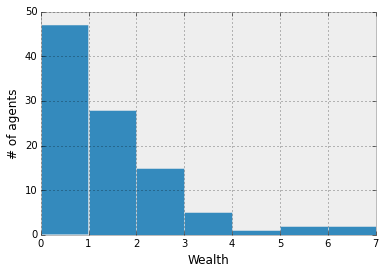

In [21]:
agent_wealths = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealths, bins=range(max(agent_wealths)+1))
plt.xlabel("Wealth")
_ = plt.ylabel("# of agents")

Despite that on average, every agent should give and get one unit of money each step, we see that most agents end up with no money, and an increasingly small number end up with more and more of it. 

Of course, this is just one random run with some particular parameters, and there's no way for us to tell whether these results are typical or not*.  So we need to run the model multiple times. Who could have guessed this is where this was going?

(*Yes, this is technically a Bolzmann distribution, which does have a closed form, but that's not what this tutorial is about.)

To do this serially on a single core, we can do something like this:


In [22]:
all_models = []
for i in range(10):
    model = MoneyModel(100)
    model.run_model(100)
    all_models.append(model)

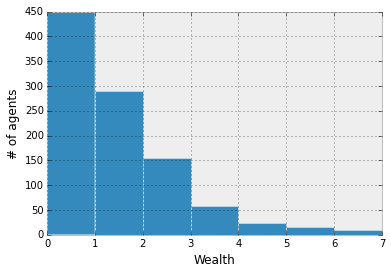

In [23]:
# Get wealths and visualize:
agent_wealths = []
for model in all_models:
    agent_wealths += [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealths, bins=range(max(agent_wealths)+1))
plt.xlabel("Wealth")
_ = plt.ylabel("# of agents")

Again, we can't just run the code as-is on all the engines: it relies not just on the Mesa-specific imports, but on the two classes we created, MoneyModel and MoneyAgent.

The imports we already know how to deal with:

In [24]:
with dview.sync_imports():
    import random
    from mesa import Model, Agent
    from mesa.time import RandomActivation

importing random on engine(s)
importing Model,Agent from mesa on engine(s)
importing RandomActivation from mesa.time on engine(s)


Next, we need to send the classes to the engines. We can send any arbitrary Python objects across using the push function, which takes a dictionary associating names for objects on the engines to the actual object to send. In this case, we want the names to stay the same.


In [25]:
dview.push({"MoneyAgent": MoneyAgent, "MoneyModel": MoneyModel})

<AsyncResult: finished>

Now we wrap up the code we want to execute in a function. It needs to take some argument, but we can just have it do nothing with it for now.


In [26]:
def make_model(_):
    model = MoneyModel(100)
    model.run_model(100)
    return model

In [27]:
all_models = dview.map_sync(make_model, [None]*10)

The resuling `all_models` list is a list of model objects, just like the one above.

In [28]:
m = all_models[0]
print("Steps completed: " + str(m.schedule.steps))

Steps completed: 100


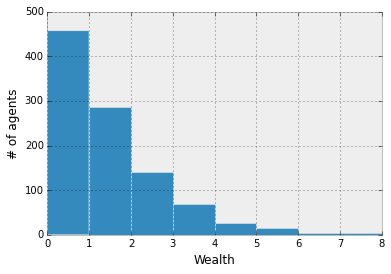

In [29]:
# Get wealths and visualize:
agent_wealths = []
for model in all_models:
    agent_wealths += [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealths, bins=range(max(agent_wealths)+1))
plt.xlabel("Wealth")
_ = plt.ylabel("# of agents")

If you time it, you'll see a substantial speedup -- not quite 4x, because the data to transfer between engines is bulkier now, but still pretty good!

In [30]:
%%timeit
all_models = []
for i in range(10):
    model = MoneyModel(100)
    model.run_model(100)
    all_models.append(model)

1 loops, best of 3: 244 ms per loop


In [31]:
%%timeit
completed_models = dview.map_sync(make_model, [None]*10)

10 loops, best of 3: 88.8 ms per loop
